## KO cCRE insilco

### load data

In [1]:
import scanpy as sc

# Load the preprocessed AnnData
# input_path = '../data/insilico/processed_h5ad/downsampled_stable_17855_cellsentenced.h5ad'
input_path = './output/finetune_IS/insilico_stable_cell_embeddings_finetuned_epoch_25.h5ad'
adata = sc.read_h5ad(input_path)

/workspace/epiagent/venv311/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


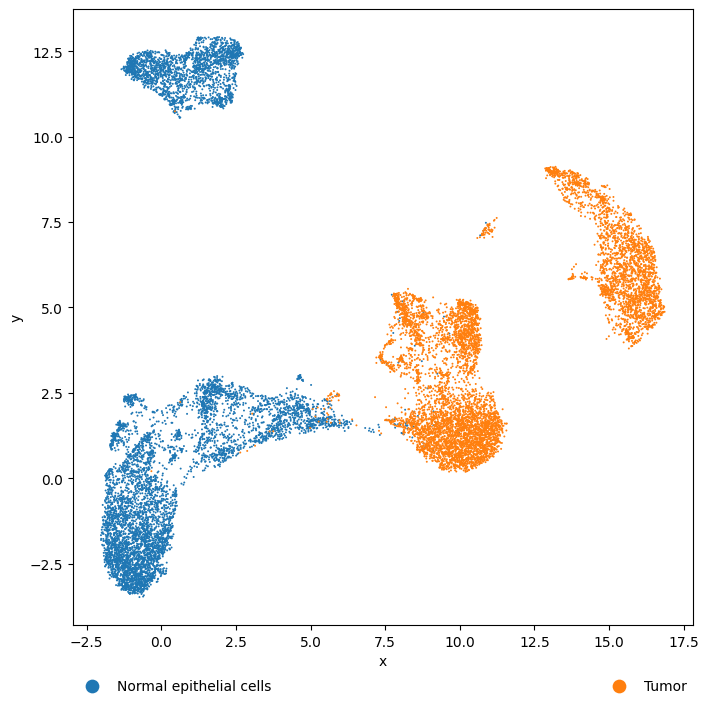

In [6]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Visualize the embeddings
adata = adata[(adata.obs['cell_type.harmonized.cancer'] == 'Tumor') | \
            (adata.obs['cell_type.harmonized.cancer'] == 'Normal epithelial cells')].copy()
umap_embeddings = umap.UMAP(n_components=2, random_state=32).fit_transform(np.array(adata.obsm['cell_embeddings']))
data = pd.DataFrame({'x': umap_embeddings[:, 0], 'y': umap_embeddings[:, 1], 'label': list(adata.obs['cell_type.harmonized.cancer'])})

plt.figure(figsize=(8,8))
sns.scatterplot(x='x', y='y', hue='label',s=2, data=data,linewidth=0)
legend = plt.legend(
    bbox_to_anchor=(0., -0.12, 1., .102), 
    loc='lower left',
    mode="expand",  
    borderaxespad=0., 
    ncol=3, 
    frameon=False, 
    markerscale=7, 
    prop={'size': 10}
)

In [7]:
import torch
import ot

torch.cuda.empty_cache()

# Matching between Normal cells and Tumor cells
normal_indices = np.array(adata.obs['cell_type.harmonized.cancer'] == 'Normal epithelial cells')
tumor_indices = np.array(adata.obs['cell_type.harmonized.cancer'] == 'Tumor')
cell_embeddings = np.array(adata.obsm['cell_embeddings'])

normal = cell_embeddings[normal_indices]
tumor = cell_embeddings[tumor_indices]
M = ot.dist(normal, tumor, metric='cosine')
G = ot.emd(torch.ones(normal.shape[0]) / normal.shape[0],
           torch.ones(tumor.shape[0]) / tumor.shape[0],
           torch.tensor(M), numItermax=100000)
match_idx = torch.max(G, 0)[1].numpy()

normal_matrix = adata[adata.obs['cell_type.harmonized.cancer']=='Normal epithelial cells',:].X.toarray()
normal_matrix = normal_matrix[match_idx,:]
tumor_matrix = adata[adata.obs['cell_type.harmonized.cancer']=='Tumor',:].X.toarray()

/workspace/epiagent/venv311/lib/python3.11/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


### load model

In [8]:
from epiagent.model import EpiAgent

# Load the model
model_path = '../model/finetune_IS_epoch50_stable_17855/checkpoint_IS_epoch_25_stable.pth'
model = EpiAgent(
    vocab_size=1355449,
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    use_flash_attn=True,
    pos_weight_for_RLM=torch.tensor(1.),
    pos_weight_for_CCA=torch.tensor(1.)
)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

/workspace/epiagent/venv311/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/workspace/epiagent/venv311/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/workspace/epiagent/venv311/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/workspace/epiagent/venv311/lib/python3.11/site-packages/flash_attn/ops/triton/layer_norm.py:984: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fw

EpiAgent(
  (cCRE_embedding): Embedding(1355449, 512)
  (rank_embedding): Embedding(8192, 512)
  (EpiAgent_transformer): BertEncoder(
    (layers): ModuleList(
      (0-17): 18 x Block(
        (mixer): MHA(
          (Wqkv): LinearResidual(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashSelfAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (inner_cross_attn): FlashCrossAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (drop_path1): StochasticDepth(p=0.0, mode=row)
        (norm1): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (d

### construct contrastive dataset

In [14]:
adata

AnnData object with n_obs × n_vars = 15326 × 1355445
    obs: 'Merged_barcode', 'Sample', 'Case_ID', 'Piece_ID', 'Sample_type', 'data.type', 'Chemistry', 'Cancer', 'cell_type.harmonized.cancer', 'Aliquot', 'GEO.sample', 'cell_sentences'
    uns: 'Sample_type_colors', 'cell_type.harmonized.cancer_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'cell_embeddings'
    obsp: 'connectivities', 'distances'

In [13]:
adata.n_obs

15326

In [15]:
np.random.seed(42)
random_numbers = np.random.uniform(0, 1, size=int(adata.n_obs/2))

import scipy.sparse as sp
from tqdm import tqdm

rows = []
cols = []
data = []
num_cols = normal_matrix.shape[1]
max_length = 8190
row = normal_matrix.shape[0]

for i in tqdm(range(row)):
    # Set the random seed
    np.random.seed(i)
    
    p = random_numbers[i]
    row_index = i % normal_matrix.shape[0]

    target_length = 8189
    normal_non_zero_cols = np.nonzero(normal_matrix[row_index, :])[0]
    tumor_non_zero_cols = np.nonzero(tumor_matrix[row_index, :])[0]

    # Number of non-zero columns in the normal and tumor cells
    n1 = len(normal_non_zero_cols)
    n2 = len(tumor_non_zero_cols)

    # Take the intersection
    non_zero_cols = np.intersect1d(normal_non_zero_cols, tumor_non_zero_cols)
    normal_non_zero_cols_no_overlap = np.setdiff1d(normal_non_zero_cols, non_zero_cols)
    tumor_non_zero_cols_no_overlap = np.setdiff1d(tumor_non_zero_cols, non_zero_cols)
    n0 = len(non_zero_cols)
    
    # Step 1: Sample n0 * p and n0 * (1 - p) portions separately from the n0 subset
    index_normal_1 = np.random.choice(non_zero_cols, int(n0 * (1 - p)), replace=False)
    index_cancer_1 = np.setdiff1d(non_zero_cols, index_normal_1)
    
    # Step 2: Sampling from the remaining portion
    # Calculate the maximum possible n3 that can be sampled from the remaining portion
    n3 = min((n1 - n0) / (1 - p), (n2 - n0) / p)
    
    # Sample n3 * (1 - p) and n3 * p from the remaining portion
    index_normal_2 = np.random.choice(normal_non_zero_cols_no_overlap, int(n3 * (1 - p)), replace=False)
    index_cancer_2 = np.random.choice(tumor_non_zero_cols_no_overlap, int(n3 * p), replace=False)
    
    # Step 3: Concatenate the sentences and truncate them to a maximum length of 8190
    total_indices = np.sort(np.concatenate([index_normal_1, index_cancer_1, index_normal_2, index_cancer_2]))
    n_final = len(total_indices)
    
    if n_final > max_length:
        # Proportional sampling
        sampling_ratio = max_length / n_final
        index_normal_1 = np.random.choice(index_normal_1, int(len(index_normal_1) * sampling_ratio), replace=False)
        index_cancer_1 = np.random.choice(index_cancer_1, int(len(index_cancer_1) * sampling_ratio), replace=False)
        index_normal_2 = np.random.choice(index_normal_2, int(len(index_normal_2) * sampling_ratio), replace=False)
        index_cancer_2 = np.random.choice(index_cancer_2, int(len(index_cancer_2) * sampling_ratio), replace=False)
    
    index_normal = np.sort(np.concatenate([index_normal_1, index_normal_2]))
    index_cancer = np.sort(np.concatenate([index_cancer_1, index_cancer_2]))

    mask_normal = np.zeros(num_cols, dtype=bool)
    mask_normal[index_normal] = True

    mask_cancer = np.zeros(num_cols, dtype=bool)
    mask_cancer[index_cancer] = True
    
    # Retrieve the original rows from the normal cells and modify them
    a = np.copy(normal_matrix[row_index, :])
    a[mask_normal == False] = 0
    a[mask_cancer] = tumor_matrix[row_index, mask_cancer]
    
    # Find the non-zero elements and add them to the row, column, and data lists of the sparse matrix
    non_zero_cols = np.nonzero(a)[0]
    rows.extend([i] * len(non_zero_cols))
    cols.extend(non_zero_cols)
    data.extend(a[non_zero_cols])

# 확인용 
print(index_normal_1)
    
result = sp.csr_matrix((data, (rows, cols)), shape=(normal_matrix.shape[0], num_cols))

adata_temp = sc.AnnData(result)
cell_type = ['intermediate'] * adata_temp.n_obs
p = list(random_numbers)
adata_temp.obs['cell_type.harmonized.cancer'] = cell_type
# adata_temp.obs['p'] = p
adata_temp.obs['p'] = random_numbers[:adata_temp.n_obs] # 수정 

adata_temp_path = './output/finetune_IS/insilico_stable_otmatched_contrastive_filter_intermediate.h5ad'
adata_temp.write(adata_temp_path)
print(f'save to: {adata_temp_path}')

100%|██████████| 7383/7383 [03:22<00:00, 36.50it/s]


[1135221  438671   75370  741669 1049050  102586 1103627]
save to: ./output/finetune_IS/insilico_stable_otmatched_contrastive_filter_intermediate.h5ad


In [16]:
from scipy.sparse import csr_matrix

adata = sc.read_h5ad(adata_temp_path)

# TF-IDF
column_sums = adata.X.sum(axis=0)
column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
row_sums = adata.X.sum(axis=1)
row_sums_inv = csr_matrix(np.reciprocal(row_sums.A.flatten()))
adata.X = adata.X.multiply(row_sums_inv.T)
adata.X = adata.X.multiply(column_sums_inv)
adata.X.data = np.log1p(adata.X.data * 10000 * 5500000)

data = {}
if not data:
    data['cell_indices'] = []
    for key in adata.obs.keys():
        data[key] = []
for key in data.keys():
    if key!='cell_indices':
        data[key] += adata.obs[key].tolist()
for i, cell in enumerate(adata):
    cell_array = cell.X.toarray().reshape(-1)
    non_zero_indices = np.nonzero(cell_array)[0]
    sorted_indices = non_zero_indices[np.argsort(-cell_array[non_zero_indices])] + 4
    sorted_indices = list(sorted_indices)
    data['cell_indices'].append(list(sorted_indices))

df = pd.DataFrame(data)
df.index = adata.obs.index
df.to_csv("./output/finetune_IS/fetal.csv")
df = pd.read_csv("./output/finetune_IS/fetal.csv",index_col=0)   
adata.obs = df
save_path = './output/finetune_IS/insilico_stable_otmatched_contrastive_tfidf.h5ad'
adata.write(save_path)
print(f"save to: {save_path}")

/tmp/ipykernel_334494/2401124123.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/anndata.py:740: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


save to: ./output/finetune_IS/insilico_stable_otmatched_contrastive_tfidf.h5ad


In [ ]:
from epiagent.dataset import CellDataset, collate_fn
import json
from torch.cuda.amp import autocast

adata_path = save_path
adata = sc.read_h5ad(adata_path)
All_data = adata.obs
cell_indeces = [json.loads(instance) for instance in All_data['cell_indices'].tolist()]
cell_type = All_data['cell_type.harmonized.cancer'].tolist()
cell_dataset = CellDataset(cell_indeces,8192,True)
test_dataloader = torch.utils.data.DataLoader(cell_dataset, batch_size=8, shuffle=False,num_workers=8, collate_fn=collate_fn)

cell_embeddings = []
for _, batch in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    input_ids = batch.to(device)
    with autocast():
        output_embeddings = model(input_ids)['transformer_outputs'][:,0,:].cpu().detach().numpy()
    input_ids = input_ids.cpu().detach().numpy()
    for output_embedding in output_embeddings:
        cell_embeddings.append(output_embedding)
cell_embeddings = np.array(cell_embeddings)

adata.obsm['embedding_insilico'] = cell_embeddings
save_path = './output/finetune_IS/insilico_stable_otmatched_contrastive_tfidf_embedding.h5ad'
adata.write(save_path)
print(f"save to: {save_path}")

/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_334494/2317522182.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


save to: ./output/finetune_IS/insilico_stable_otmatched_contrastive_tfidf_embedding.h5ad


- 시각화

/workspace/epiagent/venv311/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/workspace/epiagent/venv311/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


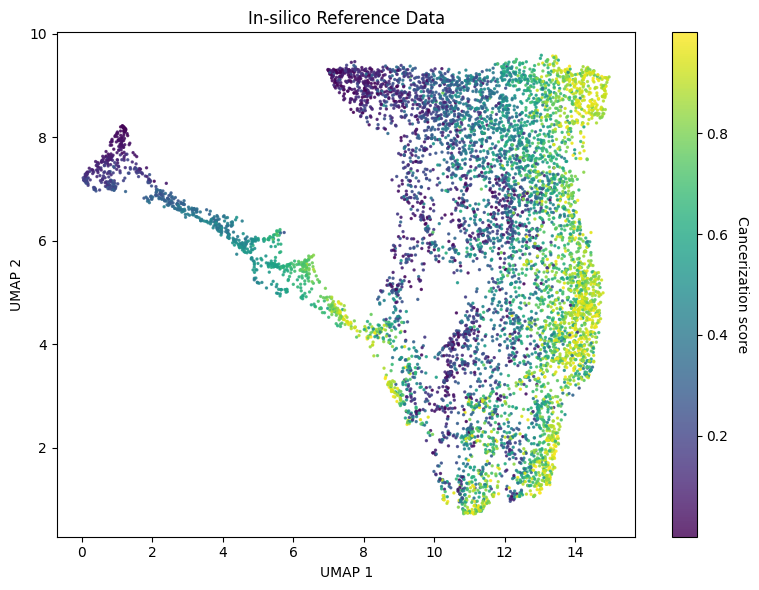

In [ ]:
embedding = adata.obsm['embedding_insilico']
p_values = adata.obs['p'].astype(float)
umap_embeddings = umap.UMAP(n_components=2, random_state=32).fit_transform(np.array(embedding))

# data = pd.DataFrame({'x': umap_embeddings[:, 0], 'y': umap_embeddings[:, 1], 'label': list(p_values)})
# plt.figure(figsize=(8,8))
# sns.scatterplot(x='x', y='y', hue='label',s=2, data=data,linewidth=0)
# legend = plt.legend(
#     bbox_to_anchor=(0., -0.12, 1., .102), 
#     loc='lower left',
#     mode="expand",  
#     borderaxespad=0., 
#     ncol=3, 
#     frameon=False, 
#     markerscale=7, 
#     prop={'size': 10}
# )


embedding = adata.obsm['embedding_insilico']
p_values = adata.obs['p'].astype(float)
umap_embeddings = umap.UMAP(n_components=2, random_state=32).fit_transform(np.array(embedding))
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=p_values,
    cmap='viridis',
    s=2,
    alpha=0.8
)
cbar = plt.colorbar(sc)
cbar.set_label("Cancerization score", rotation=270, labelpad=15)  # p value
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("In-silico Reference Data")
plt.tight_layout()
plt.show()

### KO test : EGLN3

In [29]:
import scanpy as sc

In [30]:
# Load the preprocessed AnnData
input_path = './output/finetune_IS/insilico_stable_cell_embeddings_finetuned_epoch_25.h5ad'
adata = sc.read_h5ad(input_path)

# Set the column corresponding to the promoter of EGLN3 to 0
promoter_peak = 'chr14:34035627-34036191'
idx_promoter = np.where(adata.var_names == promoter_peak)[0][0]
normal_matrix[:,idx_promoter] = 0
tumor_matrix[:,idx_promoter] = 0

In [31]:
import scipy.sparse as sp
from tqdm import tqdm

rows = []
cols = []
data = []
num_cols = normal_matrix.shape[1]
max_length = 8189
row = normal_matrix.shape[0]

for i in tqdm(range(row)):
    # Set the random seed
    np.random.seed(i)
    
    p = 0.5
    row_index = i % normal_matrix.shape[0]

    target_length = 8189
    normal_non_zero_cols = np.nonzero(normal_matrix[row_index, :])[0]
    tumor_non_zero_cols = np.nonzero(tumor_matrix[row_index, :])[0]

    # Number of non-zero columns in the normal and tumor cells
    n1 = len(normal_non_zero_cols)
    n2 = len(tumor_non_zero_cols)

    # Take the intersection
    non_zero_cols = np.intersect1d(normal_non_zero_cols, tumor_non_zero_cols)
    normal_non_zero_cols_no_overlap = np.setdiff1d(normal_non_zero_cols, non_zero_cols)
    tumor_non_zero_cols_no_overlap = np.setdiff1d(tumor_non_zero_cols, non_zero_cols)
    n0 = len(non_zero_cols)
    
    # Step 1: Sample n0 * p and n0 * (1 - p) portions separately from the n0 subset
    index_normal_1 = np.random.choice(non_zero_cols, int(n0 * (1 - p)), replace=False)
    index_cancer_1 = np.setdiff1d(non_zero_cols, index_normal_1)
    
    # Step 2: Sampling from the remaining portion
    # Calculate the maximum possible n3 that can be sampled from the remaining portion
    n3 = min((n1 - n0) / (1 - p), (n2 - n0) / p)
    
    # Sample n3 * (1 - p) and n3 * p from the remaining portion
    index_normal_2 = np.random.choice(normal_non_zero_cols_no_overlap, int(n3 * (1 - p)), replace=False)
    index_cancer_2 = np.random.choice(tumor_non_zero_cols_no_overlap, int(n3 * p), replace=False)
    
    # Step 3: Concatenate the sentences and truncate them to a maximum length of 8190
    total_indices = np.sort(np.concatenate([index_normal_1, index_cancer_1, index_normal_2, index_cancer_2]))
    n_final = len(total_indices)
    
    if n_final > max_length:
        # Proportional sampling
        sampling_ratio = max_length / n_final
        index_normal_1 = np.random.choice(index_normal_1, int(len(index_normal_1) * sampling_ratio), replace=False)
        index_cancer_1 = np.random.choice(index_cancer_1, int(len(index_cancer_1) * sampling_ratio), replace=False)
        index_normal_2 = np.random.choice(index_normal_2, int(len(index_normal_2) * sampling_ratio), replace=False)
        index_cancer_2 = np.random.choice(index_cancer_2, int(len(index_cancer_2) * sampling_ratio), replace=False)
    
    index_normal = np.sort(np.concatenate([index_normal_1, index_normal_2]))
    index_cancer = np.sort(np.concatenate([index_cancer_1, index_cancer_2]))

    mask_normal = np.zeros(num_cols, dtype=bool)
    mask_normal[index_normal] = True

    mask_cancer = np.zeros(num_cols, dtype=bool)
    mask_cancer[index_cancer] = True
    
    # Retrieve the original rows from the normal cells and modify them
    a = np.copy(normal_matrix[row_index, :])
    a[mask_normal == False] = 0
    a[mask_cancer] = tumor_matrix[row_index, mask_cancer]
    
    # Find the non-zero elements and add them to the row, column, and data lists of the sparse matrix
    non_zero_cols = np.nonzero(a)[0]
    rows.extend([i] * len(non_zero_cols))
    cols.extend(non_zero_cols)
    data.extend(a[non_zero_cols])
    rows.append(i)
    cols.append(idx_promoter)
    data.append(1)
    
result = sp.csr_matrix((data, (rows, cols)), shape=(normal_matrix.shape[0], num_cols))

adata_temp = sc.AnnData(result)
cell_type = ['intermediate'] * adata_temp.n_obs
p = [0.5] * adata_temp.n_obs
adata_temp.obs['cell_type'] = cell_type
adata_temp.obs['p'] = p
adata_temp.write('./output/finetune_IS/KO/filter_intermediate_adata_05_with_EGLN3p.h5ad')
print('save to: ./output/finetune_IS/KO/filter_intermediate_adata_05_with_EGLN3p.h5ad')

100%|██████████| 7383/7383 [03:29<00:00, 35.17it/s]


save to: ./output/finetune_IS/KO/filter_intermediate_adata_05_with_EGLN3p.h5ad


In [33]:
from scipy.sparse import csr_matrix

adata = sc.read_h5ad('./output/finetune_IS/KO/filter_intermediate_adata_05_with_EGLN3p.h5ad')

# TF-IDF
column_sums = adata.X.sum(axis=0)
column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
row_sums = adata.X.sum(axis=1)
row_sums_inv = csr_matrix(np.reciprocal(row_sums.A.flatten()))
adata.X = adata.X.multiply(row_sums_inv.T)
adata.X = adata.X.multiply(column_sums_inv)
adata.X.data = np.log1p(adata.X.data * 10000 * 5500000)

data = {}
if not data:
    data['cell_indices'] = []
    for key in adata.obs.keys():
        data[key] = []
for key in data.keys():
    if key!='cell_indices':
        data[key] += adata.obs[key].tolist()
for i, cell in enumerate(adata):
    cell_array = cell.X.toarray().reshape(-1)
    non_zero_indices = np.nonzero(cell_array)[0]
    sorted_indices = non_zero_indices[np.argsort(-cell_array[non_zero_indices])] + 4
    sorted_indices = list(sorted_indices)
    data['cell_indices'].append(list(sorted_indices))

df = pd.DataFrame(data)
df.index = adata.obs.index
df.to_csv("./output/finetune_IS/KO/fetal_05_with_EGLN3p.csv")
df = pd.read_csv("./output/finetune_IS/KO/fetal_05_with_EGLN3p.csv",index_col=0)   
adata.obs = df
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_EGLN3p.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_EGLN3p.h5ad")

/tmp/ipykernel_334494/3136312401.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/anndata.py:740: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_EGLN3p.h5ad


In [43]:
from epiagent.dataset import CellDataset, collate_fn
import json
from torch.cuda.amp import autocast

adata_path = "./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_EGLN3p.h5ad"
adata = sc.read_h5ad(adata_path)
All_data = adata.obs
cell_indeces = [json.loads(instance) for instance in All_data['cell_indices'].tolist()]
cell_type = All_data['cell_type'].tolist()
cell_dataset = CellDataset(cell_indeces,8192,True)
test_dataloader = torch.utils.data.DataLoader(cell_dataset, batch_size=8, shuffle=False,num_workers=8, collate_fn=collate_fn)

cell_embeddings = []
for _, batch in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    input_ids = batch.to(device)
    with autocast():
        output_embeddings = model(input_ids)['transformer_outputs'][:,0,:].cpu().detach().numpy()
    input_ids = input_ids.cpu().detach().numpy()
    for output_embedding in output_embeddings:
        cell_embeddings.append(output_embedding)
cell_embeddings = np.array(cell_embeddings)

adata.obsm['embedding_insilico'] = cell_embeddings
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_EGLN3p.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_EGLN3p.h5ad")

/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_334494/812870087.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_EGLN3p.h5ad


In [44]:
from scipy.sparse import csr_matrix

adata = sc.read_h5ad('./output/finetune_IS/KO/filter_intermediate_adata_05_with_EGLN3p.h5ad')

# TF-IDF
column_sums = adata.X.sum(axis=0)
column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
row_sums = adata.X.sum(axis=1)
row_sums_inv = csr_matrix(np.reciprocal(row_sums.A.flatten()))
adata.X = adata.X.multiply(row_sums_inv.T)
adata.X = adata.X.multiply(column_sums_inv)
adata.X.data = np.log1p(adata.X.data * 10000 * 5500000)

data = {}
if not data:
    data['cell_indices'] = []
    for key in adata.obs.keys():
        data[key] = []
for key in data.keys():
    if key!='cell_indices':
        data[key] += adata.obs[key].tolist()
for i, cell in enumerate(adata):
    cell_array = cell.X.toarray().reshape(-1)
    non_zero_indices = np.nonzero(cell_array)[0]
    sorted_indices = non_zero_indices[np.argsort(-cell_array[non_zero_indices])] + 4
    sorted_indices = list(sorted_indices)
    sorted_indices.remove(idx_promoter+4)
    data['cell_indices'].append(list(sorted_indices))

df = pd.DataFrame(data)
df.index = adata.obs.index
df.to_csv("./output/finetune_IS/KO/fetal_05_without_EGLN3p.csv")
df = pd.read_csv("./output/finetune_IS/KO/fetal_05_without_EGLN3p.csv",index_col=0)   
adata.obs = df
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_EGLN3p.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_EGLN3p.h5ad")

/tmp/ipykernel_334494/831861888.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/anndata.py:740: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_EGLN3p.h5ad


In [46]:
from epiagent.dataset import CellDataset, collate_fn
import json
from torch.cuda.amp import autocast

adata_path = "./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_EGLN3p.h5ad"
adata = sc.read_h5ad(adata_path)
All_data = adata.obs
cell_indeces = [json.loads(instance) for instance in All_data['cell_indices'].tolist()]
cell_type = All_data['cell_type'].tolist()
cell_dataset = CellDataset(cell_indeces,8192,True)
test_dataloader = torch.utils.data.DataLoader(cell_dataset, batch_size=8, shuffle=False,num_workers=8, collate_fn=collate_fn)

cell_embeddings = []
for _, batch in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    input_ids = batch.to(device)
    with autocast():  # 启用混合精度
        output_embeddings = model(input_ids)['transformer_outputs'][:,0,:].cpu().detach().numpy()
    input_ids = input_ids.cpu().detach().numpy()
    for output_embedding in output_embeddings:
        cell_embeddings.append(output_embedding)
cell_embeddings = np.array(cell_embeddings)

adata.obsm['embedding_insilico'] = cell_embeddings
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_EGLN3p.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_EGLN3p.h5ad")

/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_334494/593782451.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # 启用混合精度


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_EGLN3p.h5ad


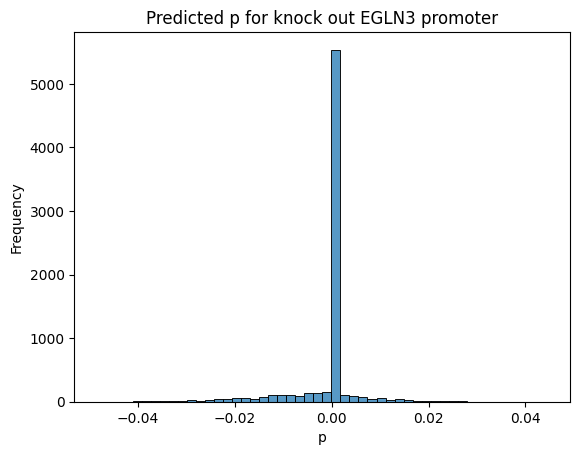

Average for knock out EGLN3 promoter: -0.0012476341716165227
Median for knock out EGLN3 promoter: 0.0
Std for knock out EGLN3 promoter: 0.006846788600288761


In [47]:
from sklearn.metrics import pairwise_distances

adata2 = sc.read_h5ad("./output/finetune_IS/insilico_stable_otmatched_contrastive_tfidf_embedding.h5ad")
embedding2 = adata2.obsm['embedding_insilico']

adata1 = sc.read_h5ad("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_EGLN3p.h5ad")
embedding1 = adata1.obsm['embedding_insilico']
distances = pairwise_distances(embedding1, embedding2, metric='euclidean')
predicted_values_with_p = []
for cell_idx in range(embedding1.shape[0]):
    nearest_neighbors_idx = np.argsort(distances[cell_idx])[:20]
    neighbor_p_values = adata2.obs.iloc[nearest_neighbors_idx]['p']
    predicted_value = neighbor_p_values.mean()
    predicted_values_with_p.append(predicted_value)
predicted_values_with_p = np.array(predicted_values_with_p)

adata1 = sc.read_h5ad("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_EGLN3p.h5ad")
embedding1 = adata1.obsm['embedding_insilico']
distances = pairwise_distances(embedding1, embedding2, metric='euclidean')
predicted_values_without_p = []
for cell_idx in range(embedding1.shape[0]):
    nearest_neighbors_idx = np.argsort(distances[cell_idx])[:20]
    neighbor_p_values = adata2.obs.iloc[nearest_neighbors_idx]['p']
    predicted_value = neighbor_p_values.mean()
    predicted_values_without_p.append(predicted_value)
predicted_values_without_p = np.array(predicted_values_without_p)

diff_score = (predicted_values_without_p - predicted_values_with_p)
sns.histplot(diff_score, kde=False, bins=50)
plt.title('Predicted p for knock out EGLN3 promoter')
plt.xlabel('p')
plt.ylabel('Frequency')
plt.show()
print(f'Average for knock out EGLN3 promoter: {np.mean(diff_score)}')
print(f'Median for knock out EGLN3 promoter: {np.median(diff_score)}')
print(f'Std for knock out EGLN3 promoter: {np.std(diff_score)}')

### KO test : ABCC1

In [48]:
import scanpy as sc

In [49]:
# Load the preprocessed AnnData
input_path = './output/finetune_IS/insilico_stable_cell_embeddings_finetuned_epoch_25.h5ad'
adata = sc.read_h5ad(input_path)

# Set the column corresponding to the promoter of ABCC1 to 0
promoter_peak = 'chr6:43427045-43428279'
idx_promoter = np.where(adata.var_names == promoter_peak)[0][0]
normal_matrix[:,idx_promoter] = 0
tumor_matrix[:,idx_promoter] = 0

In [50]:
import scipy.sparse as sp
from tqdm import tqdm

rows = []
cols = []
data = []
num_cols = normal_matrix.shape[1]
max_length = 8189
row = normal_matrix.shape[0]

for i in tqdm(range(row)):
    # Set the random seed
    np.random.seed(i)
    
    p = 0.5
    row_index = i % normal_matrix.shape[0]

    target_length = 8189
    normal_non_zero_cols = np.nonzero(normal_matrix[row_index, :])[0]
    tumor_non_zero_cols = np.nonzero(tumor_matrix[row_index, :])[0]

    # Number of non-zero columns in the normal and tumor cells
    n1 = len(normal_non_zero_cols)
    n2 = len(tumor_non_zero_cols)

    # Take the intersection
    non_zero_cols = np.intersect1d(normal_non_zero_cols, tumor_non_zero_cols)
    normal_non_zero_cols_no_overlap = np.setdiff1d(normal_non_zero_cols, non_zero_cols)
    tumor_non_zero_cols_no_overlap = np.setdiff1d(tumor_non_zero_cols, non_zero_cols)
    n0 = len(non_zero_cols)
    
    # Step 1: Sample n0 * p and n0 * (1 - p) portions separately from the n0 subset
    index_normal_1 = np.random.choice(non_zero_cols, int(n0 * (1 - p)), replace=False)
    index_cancer_1 = np.setdiff1d(non_zero_cols, index_normal_1)
    
    # Step 2: Sampling from the remaining portion
    # Calculate the maximum possible n3 that can be sampled from the remaining portion
    n3 = min((n1 - n0) / (1 - p), (n2 - n0) / p)
    
    # Sample n3 * (1 - p) and n3 * p from the remaining portion
    index_normal_2 = np.random.choice(normal_non_zero_cols_no_overlap, int(n3 * (1 - p)), replace=False)
    index_cancer_2 = np.random.choice(tumor_non_zero_cols_no_overlap, int(n3 * p), replace=False)
    
    # Step 3: Concatenate the sentences and truncate them to a maximum length of 8190
    total_indices = np.sort(np.concatenate([index_normal_1, index_cancer_1, index_normal_2, index_cancer_2]))
    n_final = len(total_indices)
    
    if n_final > max_length:
        # Proportional sampling
        sampling_ratio = max_length / n_final
        index_normal_1 = np.random.choice(index_normal_1, int(len(index_normal_1) * sampling_ratio), replace=False)
        index_cancer_1 = np.random.choice(index_cancer_1, int(len(index_cancer_1) * sampling_ratio), replace=False)
        index_normal_2 = np.random.choice(index_normal_2, int(len(index_normal_2) * sampling_ratio), replace=False)
        index_cancer_2 = np.random.choice(index_cancer_2, int(len(index_cancer_2) * sampling_ratio), replace=False)
    
    index_normal = np.sort(np.concatenate([index_normal_1, index_normal_2]))
    index_cancer = np.sort(np.concatenate([index_cancer_1, index_cancer_2]))

    mask_normal = np.zeros(num_cols, dtype=bool)
    mask_normal[index_normal] = True

    mask_cancer = np.zeros(num_cols, dtype=bool)
    mask_cancer[index_cancer] = True
    
    # Retrieve the original rows from the normal cells and modify them
    a = np.copy(normal_matrix[row_index, :])
    a[mask_normal == False] = 0
    a[mask_cancer] = tumor_matrix[row_index, mask_cancer]
    
    # Find the non-zero elements and add them to the row, column, and data lists of the sparse matrix
    non_zero_cols = np.nonzero(a)[0]
    rows.extend([i] * len(non_zero_cols))
    cols.extend(non_zero_cols)
    data.extend(a[non_zero_cols])
    rows.append(i)
    cols.append(idx_promoter)
    data.append(1)
    
result = sp.csr_matrix((data, (rows, cols)), shape=(normal_matrix.shape[0], num_cols))

adata_temp = sc.AnnData(result)
cell_type = ['intermediate'] * adata_temp.n_obs
p = [0.5] * adata_temp.n_obs
adata_temp.obs['cell_type'] = cell_type
adata_temp.obs['p'] = p
adata_temp.write('./output/finetune_IS/KO/filter_intermediate_adata_05_with_ABCC1p.h5ad')
print('save to: ./output/finetune_IS/KO/filter_intermediate_adata_05_with_ABCC1p.h5ad')

100%|██████████| 7383/7383 [03:28<00:00, 35.36it/s]


save to: ./output/finetune_IS/KO/filter_intermediate_adata_05_with_ABCC1p.h5ad


In [51]:
from scipy.sparse import csr_matrix

adata = sc.read_h5ad('./output/finetune_IS/KO/filter_intermediate_adata_05_with_ABCC1p.h5ad')

# TF-IDF
column_sums = adata.X.sum(axis=0)
column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
row_sums = adata.X.sum(axis=1)
row_sums_inv = csr_matrix(np.reciprocal(row_sums.A.flatten()))
adata.X = adata.X.multiply(row_sums_inv.T)
adata.X = adata.X.multiply(column_sums_inv)
adata.X.data = np.log1p(adata.X.data * 10000 * 5500000)

data = {}
if not data:
    data['cell_indices'] = []
    for key in adata.obs.keys():
        data[key] = []
for key in data.keys():
    if key!='cell_indices':
        data[key] += adata.obs[key].tolist()
for i, cell in enumerate(adata):
    cell_array = cell.X.toarray().reshape(-1)
    non_zero_indices = np.nonzero(cell_array)[0]
    sorted_indices = non_zero_indices[np.argsort(-cell_array[non_zero_indices])] + 4
    sorted_indices = list(sorted_indices)
    data['cell_indices'].append(list(sorted_indices))

df = pd.DataFrame(data)
df.index = adata.obs.index
df.to_csv("./output/finetune_IS/KO/fetal_05_with_ABCC1p.csv")
df = pd.read_csv("./output/finetune_IS/KO/fetal_05_with_ABCC1p.csv",index_col=0)   
adata.obs = df
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_ABCC1p.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_ABCC1p.h5ad")

/tmp/ipykernel_334494/365911024.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/anndata.py:740: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_ABCC1p.h5ad


In [52]:
from epiagent.dataset import CellDataset, collate_fn
import json
from torch.cuda.amp import autocast

adata_path = "./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_ABCC1p.h5ad"
adata = sc.read_h5ad(adata_path)
All_data = adata.obs
cell_indeces = [json.loads(instance) for instance in All_data['cell_indices'].tolist()]
cell_type = All_data['cell_type'].tolist()
cell_dataset = CellDataset(cell_indeces,8192,True)
test_dataloader = torch.utils.data.DataLoader(cell_dataset, batch_size=8, shuffle=False,num_workers=8, collate_fn=collate_fn)

cell_embeddings = []
for _, batch in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    input_ids = batch.to(device)
    with autocast():
        output_embeddings = model(input_ids)['transformer_outputs'][:,0,:].cpu().detach().numpy()
    input_ids = input_ids.cpu().detach().numpy()
    for output_embedding in output_embeddings:
        cell_embeddings.append(output_embedding)
cell_embeddings = np.array(cell_embeddings)

adata.obsm['embedding_insilico'] = cell_embeddings
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_ABCC1p.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_ABCC1p.h5ad")

/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_334494/3515285464.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_ABCC1p.h5ad


In [53]:
from scipy.sparse import csr_matrix

adata = sc.read_h5ad('./output/finetune_IS/KO/filter_intermediate_adata_05_with_ABCC1p.h5ad')

# TF-IDF
column_sums = adata.X.sum(axis=0)
column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
row_sums = adata.X.sum(axis=1)
row_sums_inv = csr_matrix(np.reciprocal(row_sums.A.flatten()))
adata.X = adata.X.multiply(row_sums_inv.T)
adata.X = adata.X.multiply(column_sums_inv)
adata.X.data = np.log1p(adata.X.data * 10000 * 5500000)

data = {}
if not data:
    data['cell_indices'] = []
    for key in adata.obs.keys():
        data[key] = []
for key in data.keys():
    if key!='cell_indices':
        data[key] += adata.obs[key].tolist()
for i, cell in enumerate(adata):
    cell_array = cell.X.toarray().reshape(-1)
    non_zero_indices = np.nonzero(cell_array)[0]
    sorted_indices = non_zero_indices[np.argsort(-cell_array[non_zero_indices])] + 4
    sorted_indices = list(sorted_indices)
    sorted_indices.remove(idx_promoter+4)
    data['cell_indices'].append(list(sorted_indices))

df = pd.DataFrame(data)
df.index = adata.obs.index
df.to_csv("./output/finetune_IS/KO/fetal_05_without_ABCC1p.csv")
df = pd.read_csv("./output/finetune_IS/KO/fetal_05_without_ABCC1p.csv",index_col=0)   
adata.obs = df
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_ABCC1p.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_ABCC1p.h5ad")

/tmp/ipykernel_334494/1718974150.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/anndata.py:740: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_ABCC1p.h5ad


In [54]:
from epiagent.dataset import CellDataset, collate_fn
import json
from torch.cuda.amp import autocast

adata_path = "./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_ABCC1p.h5ad"
adata = sc.read_h5ad(adata_path)
All_data = adata.obs
cell_indeces = [json.loads(instance) for instance in All_data['cell_indices'].tolist()]
cell_type = All_data['cell_type'].tolist()
cell_dataset = CellDataset(cell_indeces,8192,True)
test_dataloader = torch.utils.data.DataLoader(cell_dataset, batch_size=8, shuffle=False,num_workers=8, collate_fn=collate_fn)

cell_embeddings = []
for _, batch in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    input_ids = batch.to(device)
    with autocast():  # 启用混合精度
        output_embeddings = model(input_ids)['transformer_outputs'][:,0,:].cpu().detach().numpy()
    input_ids = input_ids.cpu().detach().numpy()
    for output_embedding in output_embeddings:
        cell_embeddings.append(output_embedding)
cell_embeddings = np.array(cell_embeddings)

adata.obsm['embedding_insilico'] = cell_embeddings
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_ABCC1p.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_ABCC1p.h5ad")

/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_334494/2731134074.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # 启用混合精度


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_ABCC1p.h5ad


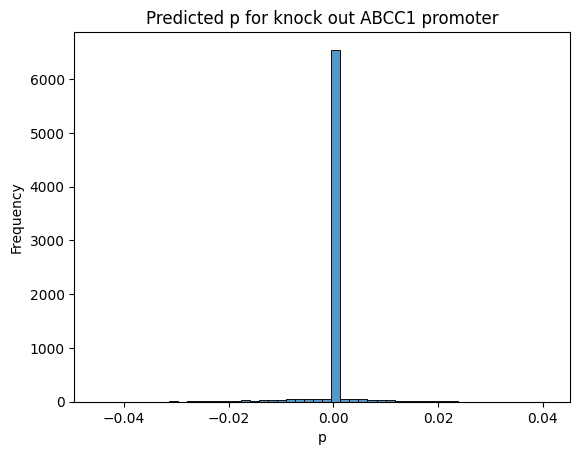

Average for knock out ABCC1 promoter: -0.00025826752832880525
Median for knock out ABCC1 promoter: 0.0
Std for knock out ABCC1 promoter: 0.004422949745685726


In [55]:
from sklearn.metrics import pairwise_distances

adata2 = sc.read_h5ad("./output/finetune_IS/insilico_stable_otmatched_contrastive_tfidf_embedding.h5ad")
embedding2 = adata2.obsm['embedding_insilico']

adata1 = sc.read_h5ad("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_ABCC1p.h5ad")
embedding1 = adata1.obsm['embedding_insilico']
distances = pairwise_distances(embedding1, embedding2, metric='euclidean')
predicted_values_with_p = []
for cell_idx in range(embedding1.shape[0]):
    nearest_neighbors_idx = np.argsort(distances[cell_idx])[:20]
    neighbor_p_values = adata2.obs.iloc[nearest_neighbors_idx]['p']
    predicted_value = neighbor_p_values.mean()
    predicted_values_with_p.append(predicted_value)
predicted_values_with_p = np.array(predicted_values_with_p)

adata1 = sc.read_h5ad("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_ABCC1p.h5ad")
embedding1 = adata1.obsm['embedding_insilico']
distances = pairwise_distances(embedding1, embedding2, metric='euclidean')
predicted_values_without_p = []
for cell_idx in range(embedding1.shape[0]):
    nearest_neighbors_idx = np.argsort(distances[cell_idx])[:20]
    neighbor_p_values = adata2.obs.iloc[nearest_neighbors_idx]['p']
    predicted_value = neighbor_p_values.mean()
    predicted_values_without_p.append(predicted_value)
predicted_values_without_p = np.array(predicted_values_without_p)

diff_score = (predicted_values_without_p - predicted_values_with_p)
sns.histplot(diff_score, kde=False, bins=50)
plt.title('Predicted p for knock out ABCC1 promoter')
plt.xlabel('p')
plt.ylabel('Frequency')
plt.show()
print(f'Average for knock out ABCC1 promoter: {np.mean(diff_score)}')
print(f'Median for knock out ABCC1 promoter: {np.median(diff_score)}')
print(f'Std for knock out ABCC1 promoter: {np.std(diff_score)}')

### KO test : VEGFA

In [56]:
import scanpy as sc

In [57]:
# Load the preprocessed AnnData
input_path = './output/finetune_IS/insilico_stable_cell_embeddings_finetuned_epoch_25.h5ad'
adata = sc.read_h5ad(input_path)

# Set the column corresponding to the promoter of VEGFA to 0
promoter_peak = 'chr6:43768813-43769358'
idx_promoter = np.where(adata.var_names == promoter_peak)[0][0]
normal_matrix[:,idx_promoter] = 0
tumor_matrix[:,idx_promoter] = 0

In [58]:
import scipy.sparse as sp
from tqdm import tqdm

rows = []
cols = []
data = []
num_cols = normal_matrix.shape[1]
max_length = 8189
row = normal_matrix.shape[0]

for i in tqdm(range(row)):
    # Set the random seed
    np.random.seed(i)
    
    p = 0.5
    row_index = i % normal_matrix.shape[0]

    target_length = 8189
    normal_non_zero_cols = np.nonzero(normal_matrix[row_index, :])[0]
    tumor_non_zero_cols = np.nonzero(tumor_matrix[row_index, :])[0]

    # Number of non-zero columns in the normal and tumor cells
    n1 = len(normal_non_zero_cols)
    n2 = len(tumor_non_zero_cols)

    # Take the intersection
    non_zero_cols = np.intersect1d(normal_non_zero_cols, tumor_non_zero_cols)
    normal_non_zero_cols_no_overlap = np.setdiff1d(normal_non_zero_cols, non_zero_cols)
    tumor_non_zero_cols_no_overlap = np.setdiff1d(tumor_non_zero_cols, non_zero_cols)
    n0 = len(non_zero_cols)
    
    # Step 1: Sample n0 * p and n0 * (1 - p) portions separately from the n0 subset
    index_normal_1 = np.random.choice(non_zero_cols, int(n0 * (1 - p)), replace=False)
    index_cancer_1 = np.setdiff1d(non_zero_cols, index_normal_1)
    
    # Step 2: Sampling from the remaining portion
    # Calculate the maximum possible n3 that can be sampled from the remaining portion
    n3 = min((n1 - n0) / (1 - p), (n2 - n0) / p)
    
    # Sample n3 * (1 - p) and n3 * p from the remaining portion
    index_normal_2 = np.random.choice(normal_non_zero_cols_no_overlap, int(n3 * (1 - p)), replace=False)
    index_cancer_2 = np.random.choice(tumor_non_zero_cols_no_overlap, int(n3 * p), replace=False)
    
    # Step 3: Concatenate the sentences and truncate them to a maximum length of 8190
    total_indices = np.sort(np.concatenate([index_normal_1, index_cancer_1, index_normal_2, index_cancer_2]))
    n_final = len(total_indices)
    
    if n_final > max_length:
        # Proportional sampling
        sampling_ratio = max_length / n_final
        index_normal_1 = np.random.choice(index_normal_1, int(len(index_normal_1) * sampling_ratio), replace=False)
        index_cancer_1 = np.random.choice(index_cancer_1, int(len(index_cancer_1) * sampling_ratio), replace=False)
        index_normal_2 = np.random.choice(index_normal_2, int(len(index_normal_2) * sampling_ratio), replace=False)
        index_cancer_2 = np.random.choice(index_cancer_2, int(len(index_cancer_2) * sampling_ratio), replace=False)
    
    index_normal = np.sort(np.concatenate([index_normal_1, index_normal_2]))
    index_cancer = np.sort(np.concatenate([index_cancer_1, index_cancer_2]))

    mask_normal = np.zeros(num_cols, dtype=bool)
    mask_normal[index_normal] = True

    mask_cancer = np.zeros(num_cols, dtype=bool)
    mask_cancer[index_cancer] = True
    
    # Retrieve the original rows from the normal cells and modify them
    a = np.copy(normal_matrix[row_index, :])
    a[mask_normal == False] = 0
    a[mask_cancer] = tumor_matrix[row_index, mask_cancer]
    
    # Find the non-zero elements and add them to the row, column, and data lists of the sparse matrix
    non_zero_cols = np.nonzero(a)[0]
    rows.extend([i] * len(non_zero_cols))
    cols.extend(non_zero_cols)
    data.extend(a[non_zero_cols])
    rows.append(i)
    cols.append(idx_promoter)
    data.append(1)
    
result = sp.csr_matrix((data, (rows, cols)), shape=(normal_matrix.shape[0], num_cols))

adata_temp = sc.AnnData(result)
cell_type = ['intermediate'] * adata_temp.n_obs
p = [0.5] * adata_temp.n_obs
adata_temp.obs['cell_type'] = cell_type
adata_temp.obs['p'] = p
adata_temp.write('./output/finetune_IS/KO/filter_intermediate_adata_05_with_VEGFAp.h5ad')
print('save to: ./output/finetune_IS/KO/filter_intermediate_adata_05_with_VEGFAp.h5ad')

100%|██████████| 7383/7383 [03:32<00:00, 34.73it/s]


save to: ./output/finetune_IS/KO/filter_intermediate_adata_05_with_VEGFAp.h5ad


In [59]:
from scipy.sparse import csr_matrix

adata = sc.read_h5ad('./output/finetune_IS/KO/filter_intermediate_adata_05_with_VEGFAp.h5ad')

# TF-IDF
column_sums = adata.X.sum(axis=0)
column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
row_sums = adata.X.sum(axis=1)
row_sums_inv = csr_matrix(np.reciprocal(row_sums.A.flatten()))
adata.X = adata.X.multiply(row_sums_inv.T)
adata.X = adata.X.multiply(column_sums_inv)
adata.X.data = np.log1p(adata.X.data * 10000 * 5500000)

data = {}
if not data:
    data['cell_indices'] = []
    for key in adata.obs.keys():
        data[key] = []
for key in data.keys():
    if key!='cell_indices':
        data[key] += adata.obs[key].tolist()
for i, cell in enumerate(adata):
    cell_array = cell.X.toarray().reshape(-1)
    non_zero_indices = np.nonzero(cell_array)[0]
    sorted_indices = non_zero_indices[np.argsort(-cell_array[non_zero_indices])] + 4
    sorted_indices = list(sorted_indices)
    data['cell_indices'].append(list(sorted_indices))

df = pd.DataFrame(data)
df.index = adata.obs.index
df.to_csv("./output/finetune_IS/KO/fetal_05_with_VEGFAp.csv")
df = pd.read_csv("./output/finetune_IS/KO/fetal_05_with_VEGFAp.csv",index_col=0)   
adata.obs = df
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_VEGFAp.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_VEGFAp.h5ad")

/tmp/ipykernel_334494/364487348.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/anndata.py:740: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_VEGFAp.h5ad


In [60]:
from epiagent.dataset import CellDataset, collate_fn
import json
from torch.cuda.amp import autocast

adata_path = "./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_with_VEGFAp.h5ad"
adata = sc.read_h5ad(adata_path)
All_data = adata.obs
cell_indeces = [json.loads(instance) for instance in All_data['cell_indices'].tolist()]
cell_type = All_data['cell_type'].tolist()
cell_dataset = CellDataset(cell_indeces,8192,True)
test_dataloader = torch.utils.data.DataLoader(cell_dataset, batch_size=8, shuffle=False,num_workers=8, collate_fn=collate_fn)

cell_embeddings = []
for _, batch in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    input_ids = batch.to(device)
    with autocast():
        output_embeddings = model(input_ids)['transformer_outputs'][:,0,:].cpu().detach().numpy()
    input_ids = input_ids.cpu().detach().numpy()
    for output_embedding in output_embeddings:
        cell_embeddings.append(output_embedding)
cell_embeddings = np.array(cell_embeddings)

adata.obsm['embedding_insilico'] = cell_embeddings
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_VEGFAp.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_VEGFAp.h5ad")

/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_334494/518463011.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_VEGFAp.h5ad


In [61]:
from scipy.sparse import csr_matrix

adata = sc.read_h5ad('./output/finetune_IS/KO/filter_intermediate_adata_05_with_VEGFAp.h5ad')

# TF-IDF
column_sums = adata.X.sum(axis=0)
column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
row_sums = adata.X.sum(axis=1)
row_sums_inv = csr_matrix(np.reciprocal(row_sums.A.flatten()))
adata.X = adata.X.multiply(row_sums_inv.T)
adata.X = adata.X.multiply(column_sums_inv)
adata.X.data = np.log1p(adata.X.data * 10000 * 5500000)

data = {}
if not data:
    data['cell_indices'] = []
    for key in adata.obs.keys():
        data[key] = []
for key in data.keys():
    if key!='cell_indices':
        data[key] += adata.obs[key].tolist()
for i, cell in enumerate(adata):
    cell_array = cell.X.toarray().reshape(-1)
    non_zero_indices = np.nonzero(cell_array)[0]
    sorted_indices = non_zero_indices[np.argsort(-cell_array[non_zero_indices])] + 4
    sorted_indices = list(sorted_indices)
    sorted_indices.remove(idx_promoter+4)
    data['cell_indices'].append(list(sorted_indices))

df = pd.DataFrame(data)
df.index = adata.obs.index
df.to_csv("./output/finetune_IS/KO/fetal_05_without_VEGFAp.csv")
df = pd.read_csv("./output/finetune_IS/KO/fetal_05_without_VEGFAp.csv",index_col=0)   
adata.obs = df
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_VEGFAp.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_VEGFAp.h5ad")

/tmp/ipykernel_334494/875899806.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  column_sums_inv = csr_matrix(np.reciprocal(column_sums.A.flatten()))
/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/anndata.py:740: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_VEGFAp.h5ad


In [62]:
from epiagent.dataset import CellDataset, collate_fn
import json
from torch.cuda.amp import autocast

adata_path = "./output/finetune_IS/KO/filter_intermediate_adata_tfidf_05_without_VEGFAp.h5ad"
adata = sc.read_h5ad(adata_path)
All_data = adata.obs
cell_indeces = [json.loads(instance) for instance in All_data['cell_indices'].tolist()]
cell_type = All_data['cell_type'].tolist()
cell_dataset = CellDataset(cell_indeces,8192,True)
test_dataloader = torch.utils.data.DataLoader(cell_dataset, batch_size=8, shuffle=False,num_workers=8, collate_fn=collate_fn)

cell_embeddings = []
for _, batch in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    input_ids = batch.to(device)
    with autocast():  # 启用混合精度
        output_embeddings = model(input_ids)['transformer_outputs'][:,0,:].cpu().detach().numpy()
    input_ids = input_ids.cpu().detach().numpy()
    for output_embedding in output_embeddings:
        cell_embeddings.append(output_embedding)
cell_embeddings = np.array(cell_embeddings)

adata.obsm['embedding_insilico'] = cell_embeddings
adata.write("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_VEGFAp.h5ad")
print("save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_VEGFAp.h5ad")

/workspace/epiagent/venv311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_334494/2022418103.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # 启用混合精度


save to: ./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_VEGFAp.h5ad


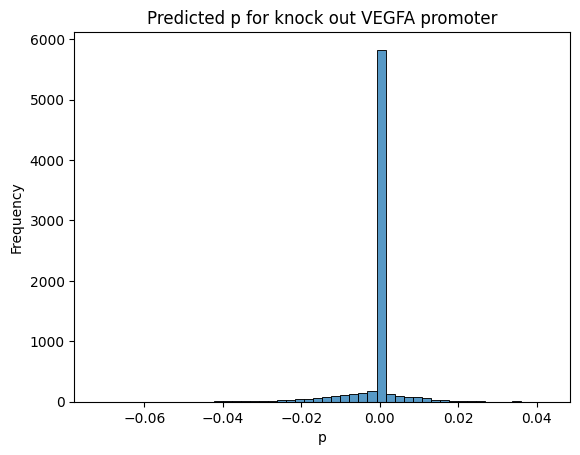

Average for knock out VEGFA promoter: -0.0007929467043138447
Median for knock out VEGFA promoter: 0.0
Std for knock out VEGFA promoter: 0.006147689759972621


In [63]:
from sklearn.metrics import pairwise_distances

adata2 = sc.read_h5ad("./output/finetune_IS/insilico_stable_otmatched_contrastive_tfidf_embedding.h5ad")
embedding2 = adata2.obsm['embedding_insilico']

adata1 = sc.read_h5ad("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_with_VEGFAp.h5ad")
embedding1 = adata1.obsm['embedding_insilico']
distances = pairwise_distances(embedding1, embedding2, metric='euclidean')
predicted_values_with_p = []
for cell_idx in range(embedding1.shape[0]):
    nearest_neighbors_idx = np.argsort(distances[cell_idx])[:20]
    neighbor_p_values = adata2.obs.iloc[nearest_neighbors_idx]['p']
    predicted_value = neighbor_p_values.mean()
    predicted_values_with_p.append(predicted_value)
predicted_values_with_p = np.array(predicted_values_with_p)

adata1 = sc.read_h5ad("./output/finetune_IS/KO/filter_intermediate_adata_tfidf_embedding_05_without_VEGFAp.h5ad")
embedding1 = adata1.obsm['embedding_insilico']
distances = pairwise_distances(embedding1, embedding2, metric='euclidean')
predicted_values_without_p = []
for cell_idx in range(embedding1.shape[0]):
    nearest_neighbors_idx = np.argsort(distances[cell_idx])[:20]
    neighbor_p_values = adata2.obs.iloc[nearest_neighbors_idx]['p']
    predicted_value = neighbor_p_values.mean()
    predicted_values_without_p.append(predicted_value)
predicted_values_without_p = np.array(predicted_values_without_p)

diff_score = (predicted_values_without_p - predicted_values_with_p)
sns.histplot(diff_score, kde=False, bins=50)
plt.title('Predicted p for knock out VEGFA promoter')
plt.xlabel('p')
plt.ylabel('Frequency')
plt.show()
print(f'Average for knock out VEGFA promoter: {np.mean(diff_score)}')
print(f'Median for knock out VEGFA promoter: {np.median(diff_score)}')
print(f'Std for knock out VEGFA promoter: {np.std(diff_score)}')

### KO overall result

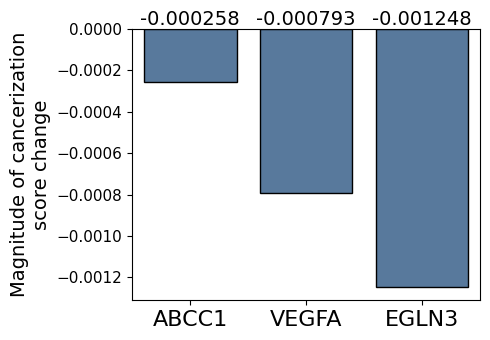

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 준비
genes = ["ABCC1", "VEGFA", "EGLN3"]
score_changes = [-0.00025826752832880525, -0.0007929467043138447, -0.0012476341716165227]
# p_values = [0.0001, 0.00001, 0.000001]  # 예시용

# 데이터프레임 생성
df = pd.DataFrame({
    "Gene": genes,
    "ScoreChange": score_changes,
    # "p_value": p_values
})

# 시각화
plt.figure(figsize=(5, 3.5))
ax = sns.barplot(x="Gene", y="ScoreChange", data=df, color="#4c78a8", edgecolor="black")

# # p-value 표시
# for i, (x, y, p) in enumerate(zip(genes, score_changes, p_values)):
#     if p < 0.0001:
#         mark = "***"
#     elif p < 0.05:
#         mark = "-"
#     else:
#         mark = ""
#     ax.text(i, y - 0.00005, mark, ha='center', va='top', fontsize=11, color='black')

# 각 막대 위에 숫자 표시
for i, (x, y) in enumerate(zip(genes, score_changes)):
    # ax.text(i, 0, f"{y:.4e}", ha='center', va='bottom', fontsize=9)
    ax.text(i, 0, f"{y:4f}", ha='center', va='bottom', fontsize=14)

# y축 라벨 및 참고 텍스트
plt.ylabel("Magnitude of cancerization\nscore change", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=16)
plt.yticks(fontsize=11)
plt.title("", loc='left')

# 참고 범례
# plt.text(1.5, min(score_changes) - 0.0004,
#          "One-side t-test\n-   p-value>0.05\n*** p-value<0.0001",
#          fontsize=10)

plt.tight_layout()
plt.show()
